In [4]:
import sys
sys.path.append("../")

In [5]:
from pathlib import Path
import numpy as np
import jax.numpy as jnp
import pandas as pd
import jax
import jraph
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/val_split/')
halos = jnp.load(data_dir / 'train_halos.npy')

## Prepare data

In [7]:
cosmology = pd.read_csv(data_dir / f'train_cosmology.csv')
print(len(cosmology))

1600


In [8]:
cosmology.head(3)

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187


In [9]:
omega_m = jnp.array(cosmology['Omega_m'].values)[:,None]

## Train EGNN

In [112]:
import flax
from flax.training.train_state import TrainState
from functools import partial
import flax.linen as nn
import optax
from tqdm import trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [113]:
from utils.graph_utils import build_graph
from models.egnn import EGNN

In [170]:
class GraphWrapper(nn.Module):
    @nn.compact
    def __call__(self, x):
        model = jax.vmap(EGNN(n_outputs=1,
                              message_passing_steps=4,
                              n_layers=2,
                              d_hidden=128,
                              activation='gelu',
                              positions_only=True, 
                              use_fourier_features=True,
                              tanh_out=False))  # Actually seems to inhibit learning in this case...
        return model(x)

In [171]:
halo_pos = halos[...,:3] / 1000.

In [172]:
k = 20
use_pbc = False
use_edges = False

graph = build_graph(halo_pos[:5], k=k, use_pbc=use_pbc, use_edges=use_edges)

In [173]:
model = GraphWrapper()

key = jax.random.PRNGKey(0)
out, params = model.init_with_output(key, graph)

In [174]:
# Devices
num_local_devices = jax.local_device_count()
print(f"{num_local_devices} GPUs available")

4 GPUs available


In [175]:
# Define train state and replicate across devices
tx = optax.adamw(learning_rate=3e-4, weight_decay=1e-5)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
pstate = replicate(state)

In [176]:
def loss_mse(pred_batch, cosmo_batch,):
    return jnp.mean((pred_batch - cosmo_batch) ** 2)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch, cosmo_batch,):

    # Build graph
    halo_graph = build_graph(halo_batch, k=k, use_pbc=use_pbc, use_edges=use_edges)
    
    def loss_fn(params):
        outputs = state.apply_fn(params, halo_graph)
        loss = loss_mse(outputs, cosmo_batch)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    return new_state, metrics

In [177]:
n_steps = 1000
n_batch = 32

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, halo_pos.shape[0], shape=(n_batch,))
        
        # halo_batch, cosmo_batch = halo_pos[idx], omega_m[idx]
        halo_batch, cosmo_batch = halo_pos[:n_batch], omega_m[:n_batch]  # Overfit on a small sample

        # Split batches across devices
        halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
        cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
        halo_batch, cosmo_batch = np.array(halo_batch), np.array(cosmo_batch)

        pstate, metrics = train_step(pstate, halo_batch, cosmo_batch)
        
        steps.set_postfix(loss=unreplicate(metrics["loss"]))

100%|██████████████████████████| 1000/1000 [01:42<00:00,  9.72it/s, loss=0.00015028678]


(32, 1)


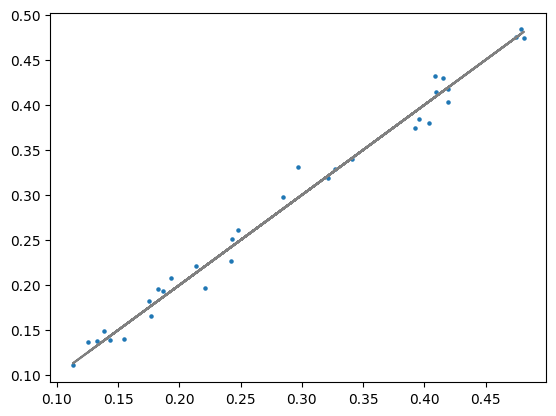

In [178]:
n_test = n_batch

graph = build_graph(halo_pos[:n_test], k=k, use_pbc=use_pbc, use_edges=use_edges)
omega_m_pred = model.apply(unreplicate(pstate).params, graph)
print(omega_m_pred.shape)

plt.scatter(omega_m[:n_test], omega_m_pred[:,0], s=5)
plt.plot(omega_m[:n_test], omega_m[:n_test], color='gray')